In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torchvision
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
from scipy.ndimage.filters import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale

# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

# Mount Google Drive folder as a local folder
# Note: This mounts your entire drive, not the current folder


C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\1776123119.py:19: DeprecationWarning: Please import `generic_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import generic_filter


In [2]:
#TODO replace the path with your path in drive
#This usually takes 5 minutes to run
!cp -r /mydrive/MyDrive/SegSTRONGC/SegSTRONGC_MLDL ./

'cp' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


In [3]:
#TODO tune your own parameters
batch_size = 10
learning_rate = 0.001
num_epochs = 10
use_gpu = False
if torch.cuda.is_available(): #use gpu if available
  use_gpu = True
  print("using cuda")

using cuda


In [4]:
import numpy as np
import os
import os.path as osp
import torch.utils.data as data
import torchvision.transforms as T
from PIL import Image

class SegSTRONGC(data.Dataset):
    def __init__(self, root_folder: str, set_indices: list, subset_indices: list, split: str = 'train', domains: list = ['regular'], image_transforms = None, gt_transforms = None, joint_transforms = None):
        '''
            reference dataset loading for SegSTRONGC
            root_folder: the root_folder of the SegSTRONGC dataset
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''
        self.split = split
        self.root_folder = root_folder
        self.set_indices = set_indices
        self.subset_indices = subset_indices
        self.domains = domains
        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms
        self.joint_transform = joint_transforms

        self.image_paths = []
        self.gt_paths = []

        for set_idx, s in enumerate(self.set_indices):
            for ss in self.subset_indices[set_idx]:
                set_folder = osp.join(self.root_folder, self.split + '/' + str(s) + '/' + str(ss))
                gt_folder = osp.join(set_folder, 'ground_truth')

                for d in self.domains:
                    image_folder = osp.join(set_folder, d)
                    for i in range(300):
                        image_name = str(i) + ".jpg"
                        gt_name = str(i) + ".png"
                        self.image_paths.append(osp.join(image_folder, 'left/' + image_name))
                        self.gt_paths.append(osp.join(gt_folder, 'left/' + gt_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx: int):
        image = np.array(Image.open(self.image_paths[idx])).astype(np.float32) / 255
        gt = (np.array(Image.open(self.gt_paths[idx])) / 255).astype(np.int64)

        # Apply transformation to image and ground truth
        if self.image_transforms is not None and self.gt_transforms is not None:
          if self.joint_transform is not None:
            augmented = self.joint_transform(image=image, mask=gt)
            image, gt = augmented['image'], augmented['mask']
          image = self.image_transforms(image)
          gt = self.gt_transforms(gt)
        else:
            image = T.ToTensor()(image)
            gt = T.ToTensor()(gt)

        return image, gt

In [5]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, useBN=False):
        super(ResidualBlock, self).__init__()
        if useBN:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
            )
        self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.block(x)
        x += shortcut
        return self.activation(x)

def upsample(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
        nn.ReLU(inplace=True)
    )

class ResUNet(nn.Module):
    def __init__(self, useBN=False):
        super(ResUNet, self).__init__()
        # Encoder
        self.conv1 = ResidualBlock(3, 32, useBN=useBN)
        self.conv2 = ResidualBlock(32, 64, useBN=useBN)
        self.conv3 = ResidualBlock(64, 128, useBN=useBN)
        self.conv4 = ResidualBlock(128, 256, useBN=useBN)
        self.conv5 = ResidualBlock(256, 512, useBN=useBN)

        # Decoder
        self.up4 = upsample(512, 256)
        self.dec4 = ResidualBlock(512, 256, useBN=useBN)

        self.up3 = upsample(256, 128)
        self.dec3 = ResidualBlock(256, 128, useBN=useBN)

        self.up2 = upsample(128, 64)
        self.dec2 = ResidualBlock(128, 64, useBN=useBN)

        self.up1 = upsample(64, 32)
        self.dec1 = ResidualBlock(64, 32, useBN=useBN)

        # Final layer
        self.final_conv = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

        # Maxpool
        self.max_pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        # Encoder
        conv1 = self.conv1(x)
        pool1 = self.max_pool(conv1)

        conv2 = self.conv2(pool1)
        pool2 = self.max_pool(conv2)

        conv3 = self.conv3(pool2)
        pool3 = self.max_pool(conv3)

        conv4 = self.conv4(pool3)
        pool4 = self.max_pool(conv4)

        conv5 = self.conv5(pool4)

        # Decoder
        up4 = self.up4(conv5)
        dec4 = self.dec4(torch.cat([up4, conv4], dim=1))

        up3 = self.up3(dec4)
        dec3 = self.dec3(torch.cat([up3, conv3], dim=1))

        up2 = self.up2(dec3)
        dec2 = self.dec2(torch.cat([up2, conv2], dim=1))

        up1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([up1, conv1], dim=1))

        # Final output
        out = self.final_conv(dec1)
        return self.sigmoid(out)

In [6]:
from tqdm import tqdm

def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    trainning_losses = []
    validation_losses = []
    epoch_trainning_losses = []
    epoch_validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in tqdm(range(num_epochs)):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            trainning_losses.append(total_training_loss / total_training_iteration)
        epoch_trainning_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        for data in validation_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          model.zero_grad()
          loss = criterion(out, y)
          total_val_loss += loss.item()
          total_val_iteration += 1
          if total_val_iteration % 100 == 99:
            validation_losses.append(total_val_loss / total_val_iteration)
        epoch_validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch,"training_loss:",total_training_loss / total_training_iteration, "validation_loss:",total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
    plt.plot(trainning_losses)
    plt.show()
    plt.plot(validation_losses)
    plt.show()
    plt.plot(epoch_trainning_losses, label='Training Loss')
    plt.plot(epoch_validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
def DICE(model, test_dataloader, smooth=1e-10):
    dice = []
    model.eval()
    for data in test_dataloader:
        img, target = data
        if use_gpu:
            img = img.cuda()
            target = target.cuda()
        predict = model(img) > 0.5
        num = 2 * (predict * target).sum()
        denum = predict.sum() + target.sum()
        dice.append(((num + smooth) / (denum + smooth)).item())
    m_dice = np.mean(dice)
    return m_dice

def DICELoss(scores, target):
    # TODO complete dice loss to calculate dice of the segmented tool according to the dice score
    scores = scores.view(-1)
    target = target.view(-1)
    num = 2 * (scores * target).sum()
    denum = scores.sum() + target.sum()
    loss = 1 - ((num + 1e-10) / (denum + 1e-10))
    return loss

In [15]:
root_folder = "./SegSTRONGC_MLDL" #TODO replace with your own path
size = (272, 480)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
train_set_indices = [3, 4, 5, 7, 8]
train_subset_indices = [[0, 2], [0, 1, 2], [0, 2], [0, 1], [1, 2]]

train_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
train_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_trainning_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms,
    gt_transforms = train_gt_transforms)
segmentation_trainning_dataloader = DataLoader(segmentation_trainning_dataset, batch_size=batch_size, shuffle=True)

val_set_indices = [1]
val_subset_indices = [[0]]

val_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
val_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
])
segmentation_validation_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = val_set_indices,
    subset_indices = val_subset_indices,
    split = 'val',
    domains = ['regular'],
    image_transforms = val_image_transforms,
    gt_transforms = val_gt_transforms)

segmentation_validation_dataloader = DataLoader(segmentation_validation_dataset, batch_size=1, shuffle=False)

test_set_indices = [9]
test_subset_indices = [[0]]

test_image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize(mean=mean, std=std)
])
test_gt_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
])
segmentation_test_dataset = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['regular'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader = DataLoader(segmentation_test_dataset, batch_size=1, shuffle=False)

segmentation_test_dataset_blood = SegSTRONGC(
    root_folder = root_folder,
    set_indices = test_set_indices,
    subset_indices = test_subset_indices,
    split = 'test',
    domains = ['blood'],
    image_transforms = test_image_transforms,
    gt_transforms = test_gt_transforms)

segmentation_test_dataloader_blood = DataLoader(segmentation_test_dataset_blood, batch_size=1, shuffle=False)


In [17]:
def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    count = 0
    for demo in test_dataset_loader:
        demo_input, demo_target = demo
        if use_gpu:
           demo_input = demo_input.cuda()
        demo_output = model(demo_input)
        for i in range(demo_input.shape[0]):
            plt.subplot(1, 3, 1)
            plt.imshow(demo_input[i].permute(1,2,0).detach().cpu().numpy())
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(demo_output[i].detach().cpu().numpy().squeeze()*255)
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(demo_target[i].detach().numpy().squeeze())
            plt.axis("off")
            plt.show()
        if count >= num:
          break
        count += 1

In [19]:
"""segmentation_model = ResUNet(useBN=True)
dice_criterion = DICELoss
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=1e-4)
trainning(segmentation_model, segmentation_trainning_dataloader, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer, "ResUnet.model")"""

'segmentation_model = ResUNet(useBN=True)\ndice_criterion = DICELoss\nsegmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=learning_rate, weight_decay=1e-4)\ntrainning(segmentation_model, segmentation_trainning_dataloader, segmentation_validation_dataloader,  num_epochs, dice_criterion, segmentation_optimizer, "ResUnet.model")'

In [21]:
"""segmentation_model.load_state_dict(torch.load("ResUnet.model"))
print(DICE(segmentation_model, segmentation_test_dataloader))
show_demo(segmentation_model, segmentation_test_dataloader)"""

'segmentation_model.load_state_dict(torch.load("ResUnet.model"))\nprint(DICE(segmentation_model, segmentation_test_dataloader))\nshow_demo(segmentation_model, segmentation_test_dataloader)'

In [23]:
"""segmentation_model.load_state_dict(torch.load("ResUnet.model"))
print(DICE(segmentation_model, segmentation_test_dataloader_blood))
show_demo(segmentation_model, segmentation_test_dataloader_blood)"""

'segmentation_model.load_state_dict(torch.load("ResUnet.model"))\nprint(DICE(segmentation_model, segmentation_test_dataloader_blood))\nshow_demo(segmentation_model, segmentation_test_dataloader_blood)'

In [25]:
#TODO add transformations in training dataset,
# Carefully think about whether the it is suitable for segmentation task
import albumentations as A
from torchvision.transforms import v2


train_image_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),                              # Convert the image to a PyTorch tensor
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),                      # Resize the image to the desired size
    transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.5)),
    v2.GaussianNoise(mean=0, sigma=0.01),
    transforms.Normalize(mean=mean, std=std),            # Normalize the image with mean and std
])

train_gt_transforms_augmented = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST),
])
joint_transforms_augmented = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ElasticTransform(p=0.2),
    ])

segmentation_trainning_dataset_augmented = SegSTRONGC(
    root_folder = root_folder,
    set_indices = train_set_indices,
    subset_indices = train_subset_indices,
    split = 'train',
    domains = ['regular'],
    image_transforms = train_image_transforms_augmented,
    gt_transforms = train_gt_transforms_augmented,
    joint_transforms=joint_transforms_augmented)
#segmentation_trainning_dataloader_augmented = DataLoader(segmentation_trainning_dataset_augmented, batch_size=batch_size, shuffle=True)

C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Training with batch_size: 16, learning_rate: 0.0001


 10%|█         | 1/10 [01:27<13:08, 87.65s/it]

epoch: 0 training_loss: 0.18770344361014987 validation_loss: 0.08869856953620911


 20%|██        | 2/10 [02:22<09:07, 68.46s/it]

epoch: 1 training_loss: 0.11102840419552752 validation_loss: 0.0810036454598109


 30%|███       | 3/10 [03:18<07:18, 62.67s/it]

epoch: 2 training_loss: 0.08334786045378532 validation_loss: 0.07738935172557831


 40%|████      | 4/10 [04:14<05:59, 59.96s/it]

epoch: 3 training_loss: 0.06898318130325004 validation_loss: 0.08087629253665606
learning_rate decayed


 50%|█████     | 5/10 [05:09<04:50, 58.15s/it]

epoch: 4 training_loss: 0.05970635897871377 validation_loss: 0.08072070904572805


 60%|██████    | 6/10 [06:05<03:50, 57.51s/it]

epoch: 5 training_loss: 0.05285272069407354 validation_loss: 0.08040894660684797


 70%|███████   | 7/10 [07:00<02:50, 56.78s/it]

epoch: 6 training_loss: 0.04781570172951582 validation_loss: 0.080125325464067


 80%|████████  | 8/10 [07:55<01:52, 56.24s/it]

epoch: 7 training_loss: 0.043976224454992635 validation_loss: 0.07991565150519211


 90%|█████████ | 9/10 [08:51<00:56, 56.04s/it]

epoch: 8 training_loss: 0.040924411912919116 validation_loss: 0.07988830475895493
learning_rate decayed


100%|██████████| 10/10 [09:47<00:00, 58.70s/it]

epoch: 9 training_loss: 0.03843801534118284 validation_loss: 0.0798007383743922


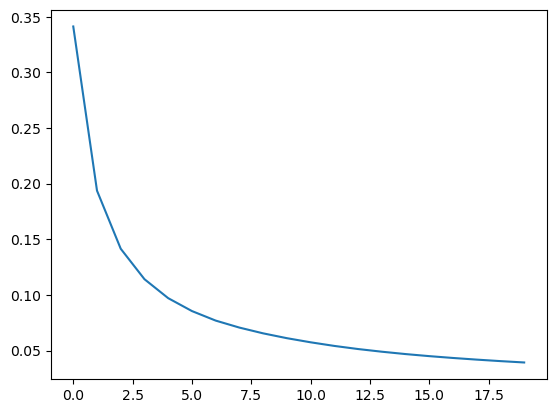

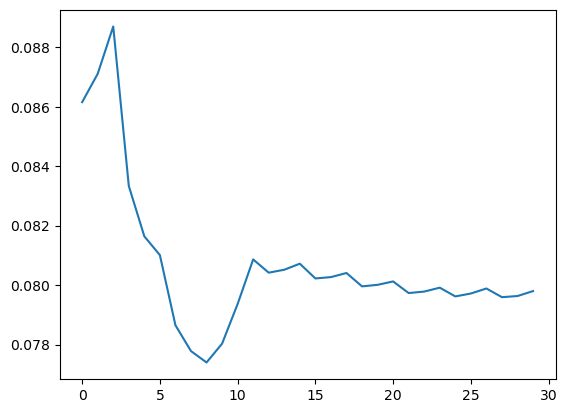

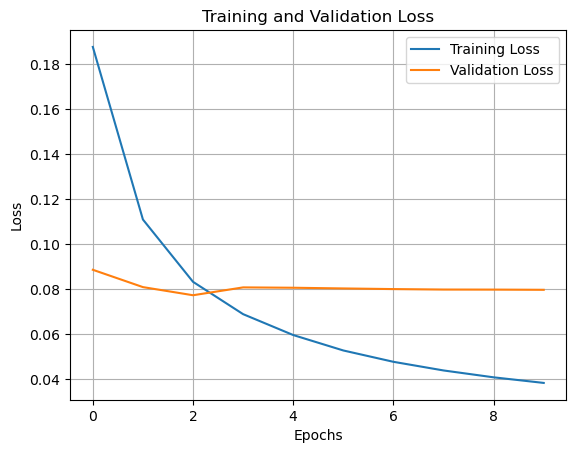

Validation Dice Score: 0.9211
Best model updated: ResUnet_best_16_0.0001.model with Dice Score: 0.9211
Training with batch_size: 16, learning_rate: 0.001


 10%|█         | 1/10 [00:55<08:18, 55.34s/it]

epoch: 0 training_loss: 0.10387442768483922 validation_loss: 0.09678235967953999


 20%|██        | 2/10 [01:50<07:21, 55.21s/it]

epoch: 1 training_loss: 0.07450556107189345 validation_loss: 0.1406102493405342


 30%|███       | 3/10 [02:45<06:25, 55.09s/it]

epoch: 2 training_loss: 0.06319129774151985 validation_loss: 0.11752521846029494


 40%|████      | 4/10 [03:58<06:13, 62.21s/it]

epoch: 3 training_loss: 0.05665005534743341 validation_loss: 0.20874762465556462
learning_rate decayed


 50%|█████     | 5/10 [05:17<05:41, 68.28s/it]

epoch: 4 training_loss: 0.05250450078991876 validation_loss: 0.18671130232016245


 60%|██████    | 6/10 [06:22<04:27, 66.98s/it]

epoch: 5 training_loss: 0.04868663110786782 validation_loss: 0.16743589474095238


 70%|███████   | 7/10 [07:17<03:09, 63.31s/it]

epoch: 6 training_loss: 0.045584955324050554 validation_loss: 0.1539888727381116


 80%|████████  | 8/10 [08:14<02:02, 61.14s/it]

epoch: 7 training_loss: 0.043130878017144506 validation_loss: 0.14420830433567364


 90%|█████████ | 9/10 [09:09<00:59, 59.41s/it]

epoch: 8 training_loss: 0.04110061501663216 validation_loss: 0.13628215886928416
learning_rate decayed


100%|██████████| 10/10 [10:04<00:00, 60.49s/it]

epoch: 9 training_loss: 0.03940937498917326 validation_loss: 0.13009526306390762


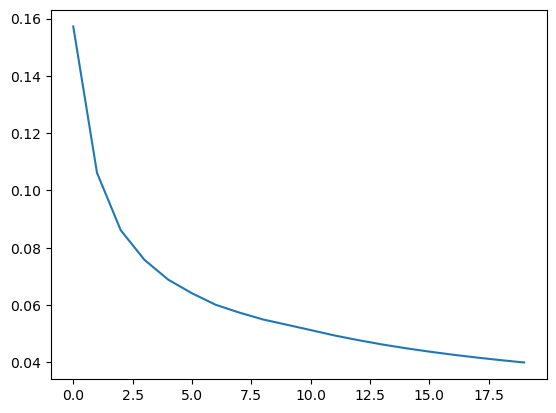

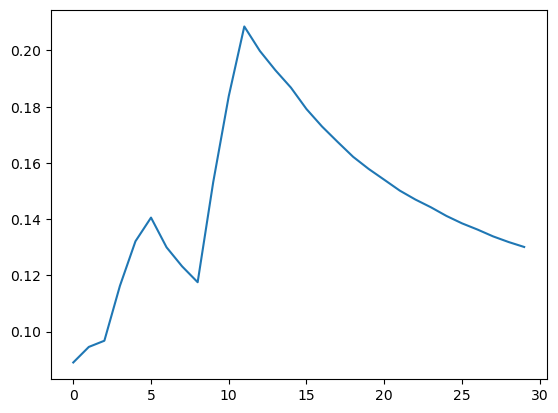

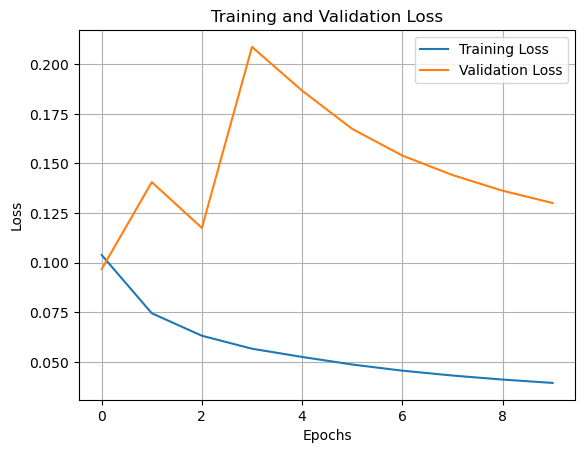

Validation Dice Score: 0.9257
Best model updated: ResUnet_best_16_0.001.model with Dice Score: 0.9257
Training with batch_size: 16, learning_rate: 0.005


 10%|█         | 1/10 [00:54<08:14, 54.92s/it]

epoch: 0 training_loss: 0.13201229756581034 validation_loss: 0.0822689801454544


 20%|██        | 2/10 [01:50<07:22, 55.25s/it]

epoch: 1 training_loss: 0.09625869427902112 validation_loss: 0.14230477104584377


 30%|███       | 3/10 [02:46<06:28, 55.53s/it]

epoch: 2 training_loss: 0.08098350189350269 validation_loss: 0.12695342030790116


 40%|████      | 4/10 [03:41<05:33, 55.50s/it]

epoch: 3 training_loss: 0.07185321592766306 validation_loss: 0.11084980651736259
learning_rate decayed


 50%|█████     | 5/10 [04:36<04:36, 55.26s/it]

epoch: 4 training_loss: 0.0664204255970204 validation_loss: 0.10018610366185506


 60%|██████    | 6/10 [05:31<03:40, 55.12s/it]

epoch: 5 training_loss: 0.06179497380187546 validation_loss: 0.09547755546040006


 70%|███████   | 7/10 [06:26<02:45, 55.04s/it]

epoch: 6 training_loss: 0.057875110331364873 validation_loss: 0.09267612414700645


 80%|████████  | 8/10 [07:21<01:50, 55.17s/it]

epoch: 7 training_loss: 0.05463488929081654 validation_loss: 0.09025396933158239


 90%|█████████ | 9/10 [08:17<00:55, 55.29s/it]

epoch: 8 training_loss: 0.05191859902071172 validation_loss: 0.08914401566540753
learning_rate decayed


100%|██████████| 10/10 [09:13<00:00, 55.37s/it]

epoch: 9 training_loss: 0.049634152161326384 validation_loss: 0.0878430469830831


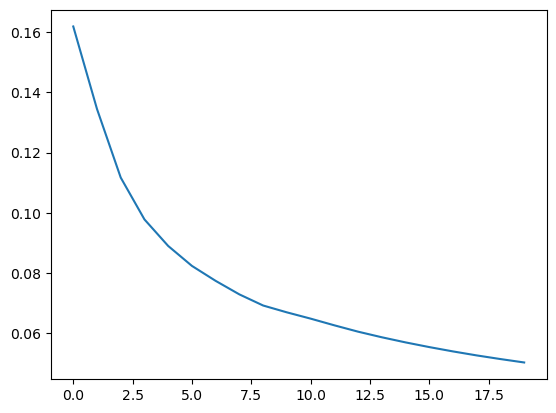

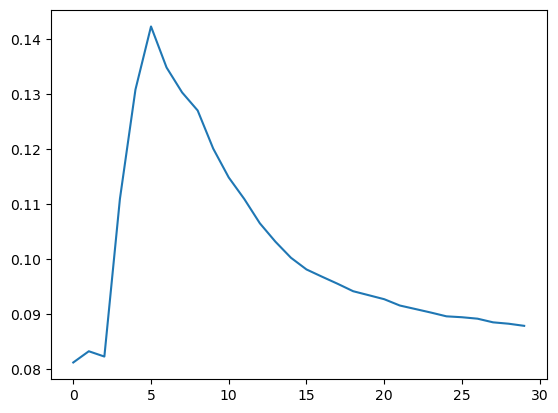

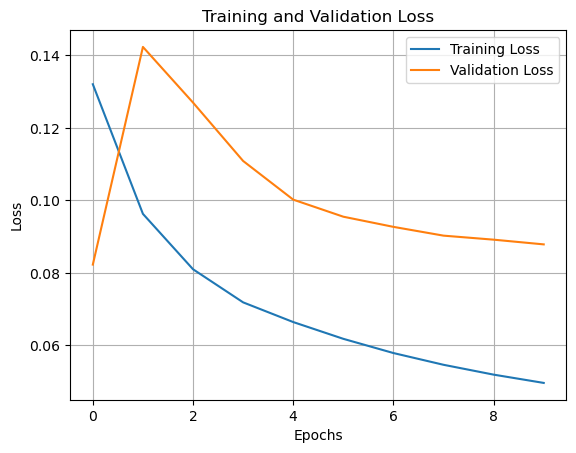

Validation Dice Score: 0.9240
Training with batch_size: 16, learning_rate: 0.01


 10%|█         | 1/10 [00:55<08:17, 55.23s/it]

epoch: 0 training_loss: 0.13761366277501202 validation_loss: 0.18874541183312735


 20%|██        | 2/10 [01:50<07:22, 55.36s/it]

epoch: 1 training_loss: 0.11313053504856313 validation_loss: 0.151798557639122


 30%|███       | 3/10 [02:45<06:25, 55.08s/it]

epoch: 2 training_loss: 0.09550328895857561 validation_loss: 0.12912731607755026


 40%|████      | 4/10 [03:41<05:33, 55.50s/it]

epoch: 3 training_loss: 0.08459713205623166 validation_loss: 0.11066993698477745
learning_rate decayed


 50%|█████     | 5/10 [04:36<04:37, 55.47s/it]

epoch: 4 training_loss: 0.07800667464445178 validation_loss: 0.10097287456194559


 60%|██████    | 6/10 [05:33<03:43, 55.79s/it]

epoch: 5 training_loss: 0.07148426291255368 validation_loss: 0.09637743675046496


 70%|███████   | 7/10 [06:29<02:47, 55.82s/it]

epoch: 6 training_loss: 0.06640552952011508 validation_loss: 0.09261615773042044


 80%|████████  | 8/10 [07:25<01:51, 55.99s/it]

epoch: 7 training_loss: 0.06241860535841633 validation_loss: 0.08886199007431667


 90%|█████████ | 9/10 [08:21<00:56, 56.07s/it]

epoch: 8 training_loss: 0.059133140713184415 validation_loss: 0.08723644700315264
learning_rate decayed


100%|██████████| 10/10 [09:19<00:00, 55.90s/it]

epoch: 9 training_loss: 0.05637474028384628 validation_loss: 0.08582878267765046


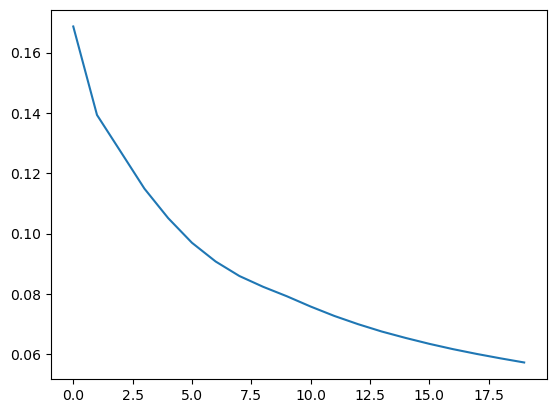

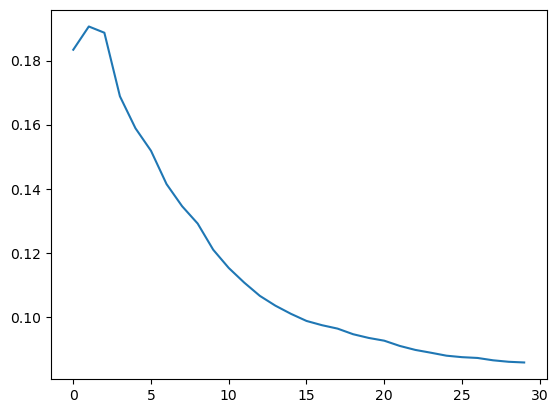

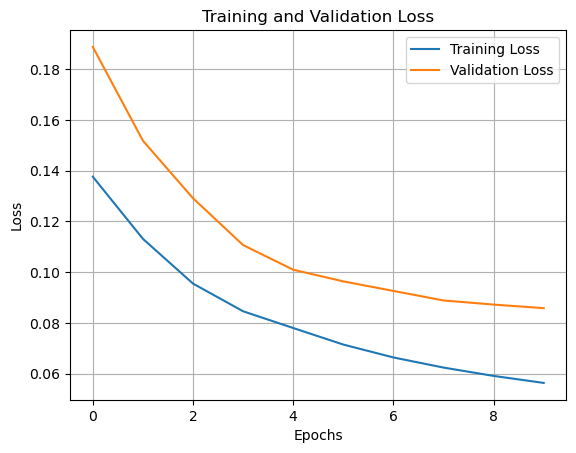

Validation Dice Score: 0.9270
Best model updated: ResUnet_best_16_0.01.model with Dice Score: 0.9270
Training with batch_size: 16, learning_rate: 0.1


 10%|█         | 1/10 [00:56<08:27, 56.36s/it]

epoch: 0 training_loss: 0.7540247189825859 validation_loss: 0.7414465379714966


 20%|██        | 2/10 [01:52<07:31, 56.46s/it]

epoch: 1 training_loss: 0.7138820985953013 validation_loss: 0.7441268736124038


 30%|███       | 3/10 [02:49<06:36, 56.58s/it]

epoch: 2 training_loss: 0.703215813483209 validation_loss: 0.7412757445043988


 40%|████      | 4/10 [03:45<05:36, 56.14s/it]

epoch: 3 training_loss: 0.6954117494360836 validation_loss: 0.7398501799503963
learning_rate decayed


 50%|█████     | 5/10 [04:40<04:38, 55.77s/it]

epoch: 4 training_loss: 0.6833722227437484 validation_loss: 0.7389948412179946


 60%|██████    | 6/10 [05:35<03:41, 55.49s/it]

epoch: 5 training_loss: 0.6814775452041779 validation_loss: 0.7384245731102096


 70%|███████   | 7/10 [06:30<02:45, 55.31s/it]

epoch: 6 training_loss: 0.6204067733141371 validation_loss: 0.6706555140869958


 80%|████████  | 8/10 [07:25<01:50, 55.22s/it]

epoch: 7 training_loss: 0.561584920986839 validation_loss: 0.5996405569463968


 90%|█████████ | 9/10 [08:20<00:55, 55.16s/it]

epoch: 8 training_loss: 0.5150715913493596 validation_loss: 0.5470943694423747
learning_rate decayed


100%|██████████| 10/10 [09:14<00:00, 55.50s/it]

epoch: 9 training_loss: 0.4775754752078494 validation_loss: 0.5024480685393016


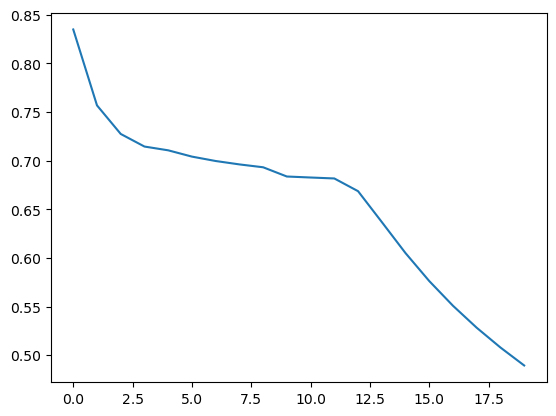

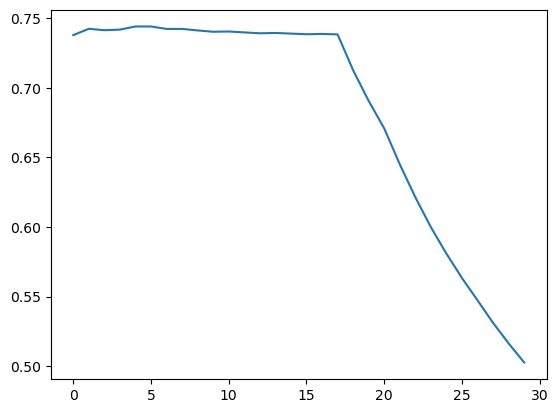

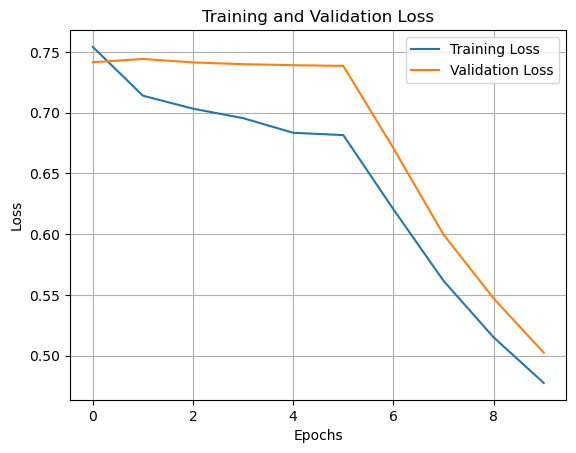

Validation Dice Score: 0.8994
Training with batch_size: 32, learning_rate: 0.0001


 10%|█         | 1/10 [00:54<08:14, 54.91s/it]

epoch: 0 training_loss: 0.37731822522786945 validation_loss: 0.07509986956914266


 20%|██        | 2/10 [01:49<07:17, 54.68s/it]

epoch: 1 training_loss: 0.20862899863949189 validation_loss: 0.07595003267129262


 30%|███       | 3/10 [02:44<06:23, 54.82s/it]

epoch: 2 training_loss: 0.14951593562578544 validation_loss: 0.07999900778134664


 40%|████      | 4/10 [03:39<05:30, 55.09s/it]

epoch: 3 training_loss: 0.11882253521336959 validation_loss: 0.0811097876727581
learning_rate decayed


 50%|█████     | 5/10 [04:35<04:35, 55.14s/it]

epoch: 4 training_loss: 0.09986207382037089 validation_loss: 0.080465412179629


 60%|██████    | 6/10 [05:29<03:39, 54.98s/it]

epoch: 5 training_loss: 0.08659048015490556 validation_loss: 0.08046122408575482


 70%|███████   | 7/10 [06:24<02:44, 54.92s/it]

epoch: 6 training_loss: 0.076964428627884 validation_loss: 0.08047910818031856


 80%|████████  | 8/10 [07:20<01:50, 55.12s/it]

epoch: 7 training_loss: 0.06970792134793904 validation_loss: 0.08020540500680605


 90%|█████████ | 9/10 [08:14<00:54, 54.97s/it]

epoch: 8 training_loss: 0.06401089547026871 validation_loss: 0.07995811442534129
learning_rate decayed


100%|██████████| 10/10 [09:10<00:00, 55.01s/it]

epoch: 9 training_loss: 0.059409878288324065 validation_loss: 0.07991172802448272


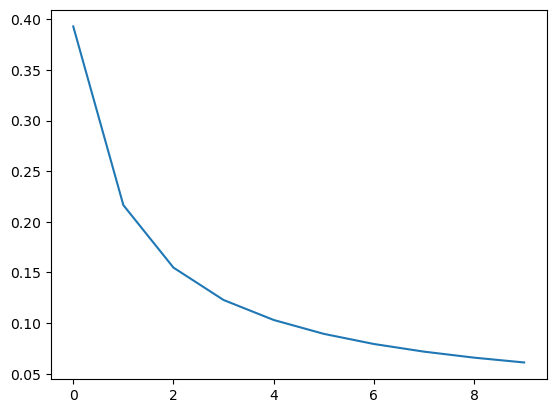

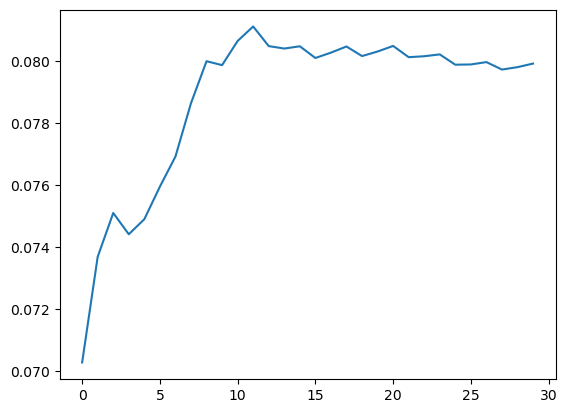

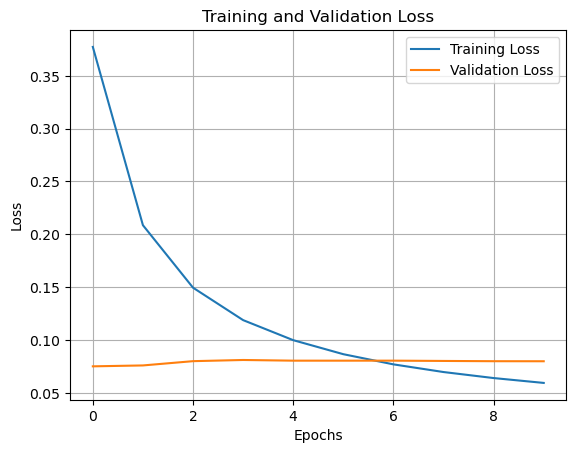

Validation Dice Score: 0.9209
Training with batch_size: 32, learning_rate: 0.001


 10%|█         | 1/10 [00:55<08:19, 55.51s/it]

epoch: 0 training_loss: 0.15705857483240274 validation_loss: 0.09009167909622193


 20%|██        | 2/10 [01:50<07:23, 55.41s/it]

epoch: 1 training_loss: 0.10378336591216233 validation_loss: 0.07499273906151453


 30%|███       | 3/10 [02:45<06:26, 55.18s/it]

epoch: 2 training_loss: 0.08256746083498001 validation_loss: 0.06643976324134403


 40%|████      | 4/10 [03:40<05:29, 54.97s/it]

epoch: 3 training_loss: 0.07148811607979812 validation_loss: 0.06502652471264203
learning_rate decayed


 50%|█████     | 5/10 [04:35<04:34, 54.98s/it]

epoch: 4 training_loss: 0.0641238339818441 validation_loss: 0.06634882283210754


 60%|██████    | 6/10 [05:30<03:39, 54.93s/it]

epoch: 5 training_loss: 0.05833158833094132 validation_loss: 0.06695527891318004


 70%|███████   | 7/10 [06:25<02:44, 54.90s/it]

epoch: 6 training_loss: 0.053954420918291744 validation_loss: 0.067019318540891


 80%|████████  | 8/10 [07:19<01:49, 54.84s/it]

epoch: 7 training_loss: 0.050559597376447454 validation_loss: 0.06719251985351245


 90%|█████████ | 9/10 [08:14<00:54, 54.81s/it]

epoch: 8 training_loss: 0.04782432769863015 validation_loss: 0.06806239430551175
learning_rate decayed


100%|██████████| 10/10 [09:09<00:00, 54.91s/it]

epoch: 9 training_loss: 0.04553688357655818 validation_loss: 0.06841701616843542


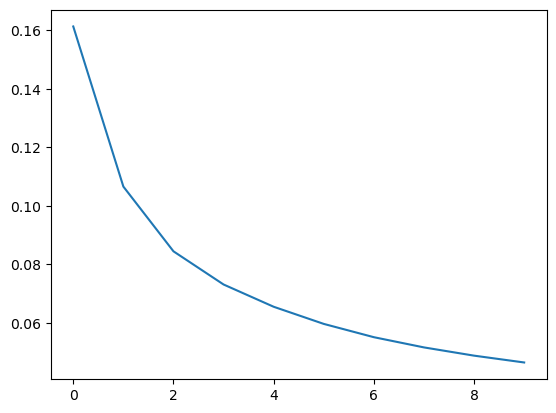

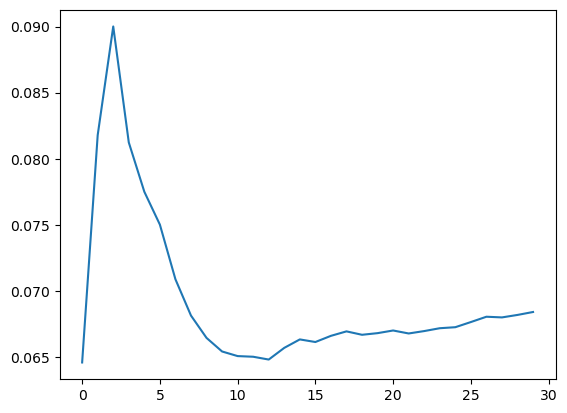

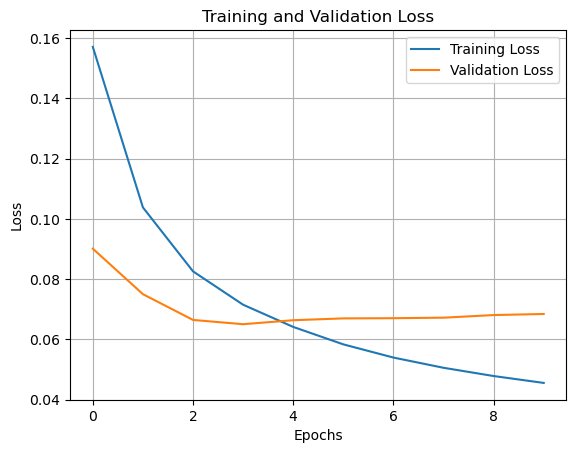

Validation Dice Score: 0.9285
Best model updated: ResUnet_best_32_0.001.model with Dice Score: 0.9285
Training with batch_size: 32, learning_rate: 0.005


 10%|█         | 1/10 [00:54<08:14, 54.91s/it]

epoch: 0 training_loss: 0.14855016366793558 validation_loss: 0.2100020945072174


 20%|██        | 2/10 [01:49<07:17, 54.63s/it]

epoch: 1 training_loss: 0.1134854921927819 validation_loss: 0.3625211056073507


 30%|███       | 3/10 [02:44<06:24, 54.87s/it]

epoch: 2 training_loss: 0.09395163659101878 validation_loss: 0.27345092687341904


 40%|████      | 4/10 [03:44<05:41, 56.85s/it]

epoch: 3 training_loss: 0.08244471538525361 validation_loss: 0.22147339930136997
learning_rate decayed


 50%|█████     | 5/10 [04:56<05:11, 62.22s/it]

epoch: 4 training_loss: 0.07417215234958209 validation_loss: 0.18945382269223532


 60%|██████    | 6/10 [06:08<04:22, 65.65s/it]

epoch: 5 training_loss: 0.06769256857343209 validation_loss: 0.16916548368003634


 70%|███████   | 7/10 [07:22<03:25, 68.38s/it]

epoch: 6 training_loss: 0.06248194748883719 validation_loss: 0.15563360472520194


 80%|████████  | 8/10 [08:37<02:20, 70.38s/it]

epoch: 7 training_loss: 0.058376939895634465 validation_loss: 0.14521993177632492


 90%|█████████ | 9/10 [09:51<01:11, 71.64s/it]

epoch: 8 training_loss: 0.05507923395205767 validation_loss: 0.1372200428556513
learning_rate decayed


100%|██████████| 10/10 [11:06<00:00, 66.67s/it]

epoch: 9 training_loss: 0.05230272847872514 validation_loss: 0.1305437942345937


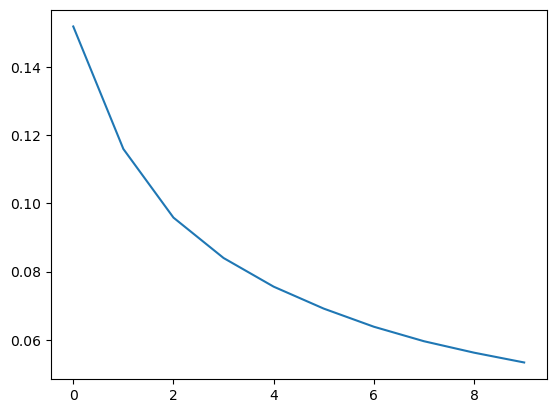

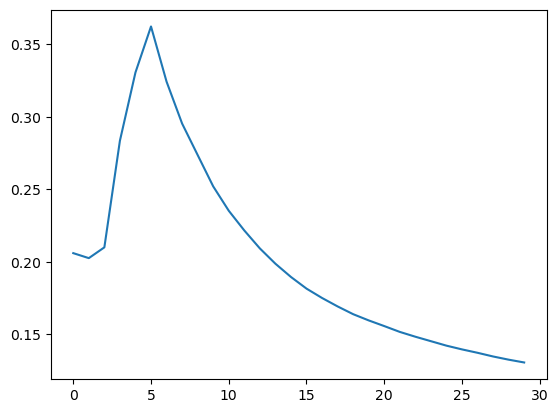

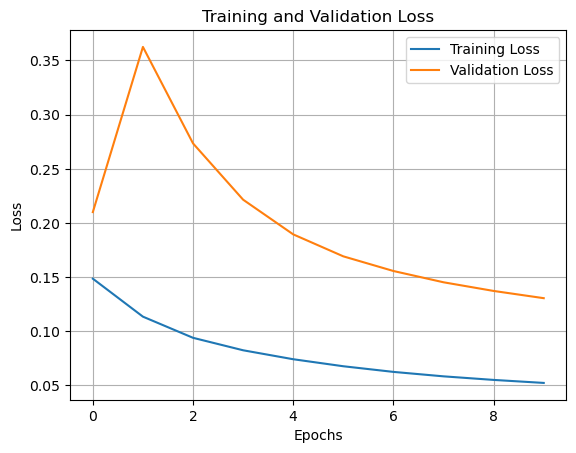

Validation Dice Score: 0.9297
Best model updated: ResUnet_best_32_0.005.model with Dice Score: 0.9297
Training with batch_size: 32, learning_rate: 0.01


 10%|█         | 1/10 [01:13<11:03, 73.75s/it]

epoch: 0 training_loss: 0.171351592701215 validation_loss: 0.5954025608301162


 20%|██        | 2/10 [02:28<09:55, 74.41s/it]

epoch: 1 training_loss: 0.14530857308552816 validation_loss: 0.5771454520026843


 30%|███       | 3/10 [03:43<08:42, 74.63s/it]

epoch: 2 training_loss: 0.13337729068902823 validation_loss: 0.40956842323144277


 40%|████      | 4/10 [04:57<07:25, 74.27s/it]

epoch: 3 training_loss: 0.1194736146583007 validation_loss: 0.33296685362855594
learning_rate decayed


 50%|█████     | 5/10 [06:12<06:12, 74.56s/it]

epoch: 4 training_loss: 0.10812521496644387 validation_loss: 0.27948440102736155


 60%|██████    | 6/10 [07:26<04:58, 74.50s/it]

epoch: 5 training_loss: 0.09754782962875488 validation_loss: 0.24212960140572654


 70%|███████   | 7/10 [08:42<03:45, 75.03s/it]

epoch: 6 training_loss: 0.08936647473128287 validation_loss: 0.2147256661029089


 80%|████████  | 8/10 [09:58<02:30, 75.17s/it]

epoch: 7 training_loss: 0.08284596203324887 validation_loss: 0.19606417939066886


 90%|█████████ | 9/10 [11:11<01:14, 74.67s/it]

epoch: 8 training_loss: 0.07753313574780765 validation_loss: 0.18277487907144757
learning_rate decayed


100%|██████████| 10/10 [12:26<00:00, 74.65s/it]

epoch: 9 training_loss: 0.07310002234119635 validation_loss: 0.17110123745600384


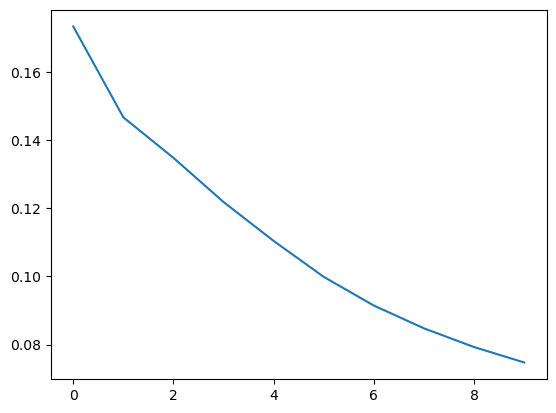

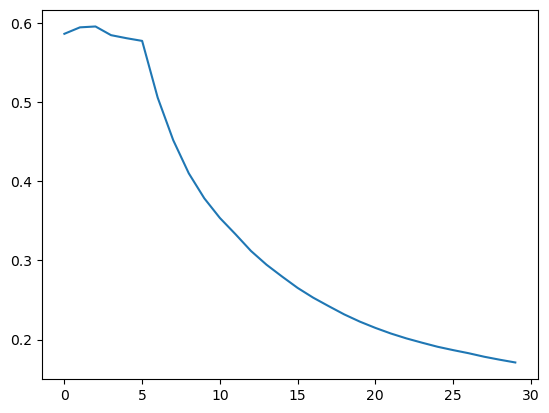

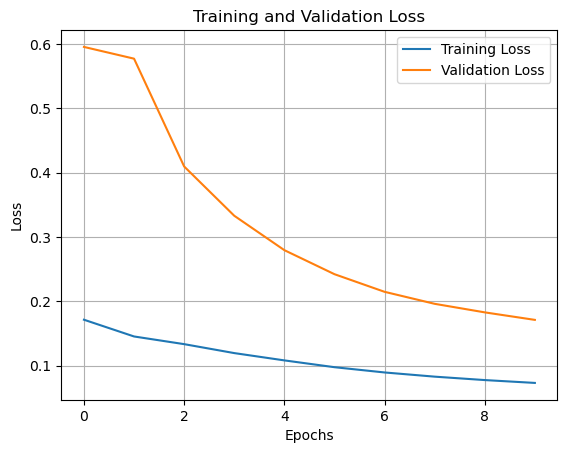

Validation Dice Score: 0.9342
Best model updated: ResUnet_best_32_0.01.model with Dice Score: 0.9342
Training with batch_size: 32, learning_rate: 0.1


 10%|█         | 1/10 [01:15<11:20, 75.63s/it]

epoch: 0 training_loss: 0.7532442819613677 validation_loss: 0.7355734862883886


 20%|██        | 2/10 [02:30<10:03, 75.40s/it]

epoch: 1 training_loss: 0.7124225626198145 validation_loss: 0.7355734862883886


 30%|███       | 3/10 [03:44<08:43, 74.80s/it]

epoch: 2 training_loss: 0.6990002145369848 validation_loss: 0.7355734862883886


 40%|████      | 4/10 [04:59<07:27, 74.53s/it]

epoch: 3 training_loss: 0.6922773683013824 validation_loss: 0.7355734862883886
learning_rate decayed


 50%|█████     | 5/10 [06:12<06:11, 74.25s/it]

epoch: 4 training_loss: 0.6882305980874942 validation_loss: 0.7355734862883886


 60%|██████    | 6/10 [07:27<04:56, 74.23s/it]

epoch: 5 training_loss: 0.6820255525601215 validation_loss: 0.7350174161460664


 70%|███████   | 7/10 [08:41<03:42, 74.15s/it]

epoch: 6 training_loss: 0.6045969093402663 validation_loss: 0.651633109393574


 80%|████████  | 8/10 [09:55<02:28, 74.32s/it]

epoch: 7 training_loss: 0.5410355313036305 validation_loss: 0.5814542787025372


 90%|█████████ | 9/10 [11:09<01:14, 74.02s/it]

epoch: 8 training_loss: 0.4911540153189602 validation_loss: 0.5252087635684897
learning_rate decayed


100%|██████████| 10/10 [12:23<00:00, 74.30s/it]

epoch: 9 training_loss: 0.450356219880856 validation_loss: 0.48074250938495


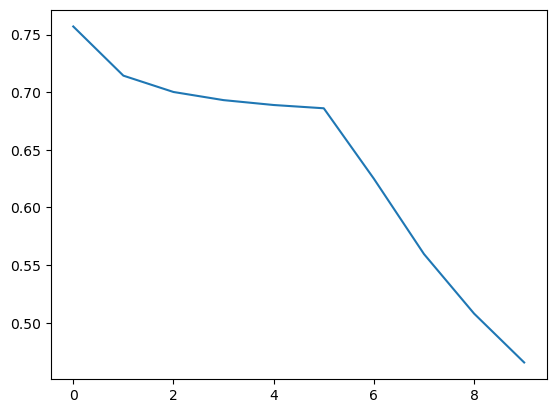

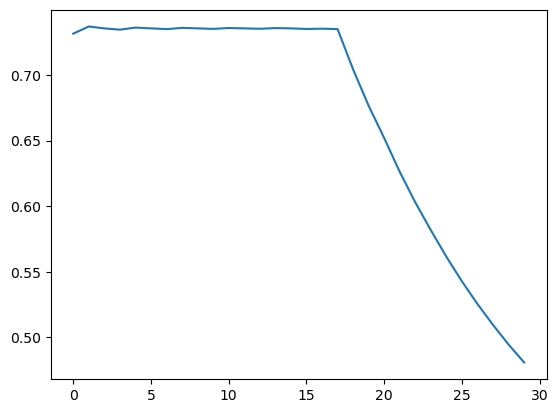

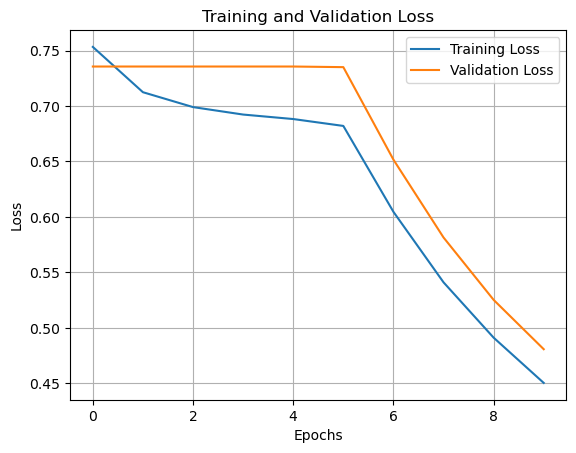

Validation Dice Score: 0.9195

All model Dice Scores:
batch_size=16_lr=0.0001: 0.9211
batch_size=16_lr=0.001: 0.9257
batch_size=16_lr=0.005: 0.9240
batch_size=16_lr=0.01: 0.9270
batch_size=16_lr=0.1: 0.8994
batch_size=32_lr=0.0001: 0.9209
batch_size=32_lr=0.001: 0.9285
batch_size=32_lr=0.005: 0.9297
batch_size=32_lr=0.01: 0.9342
batch_size=32_lr=0.1: 0.9195

Best model saved as ResUnet_best_32_0.01.model with highest Dice Score: 0.9342


In [26]:
bs = [16, 32]  # Batch sizes
lrs = [0.0001,0.001, 0.005, 0.01,0.1]  # Learning rates
num_epochs = 10
best_model = None
highest_dice_score = 0.0  # 初始最大Dice Score为0

# 存储每次训练的模型的Dice Score
model_dice_scores = {}

for batch_size in bs:
    for learning_rate in lrs:
        print(f"Training with batch_size: {batch_size}, learning_rate: {learning_rate}")
        
        # 设置数据加载器和模型
        segmentation_trainning_dataloader_augmented = DataLoader(
            segmentation_trainning_dataset_augmented, batch_size=batch_size, shuffle=True
        )
        segmentation_model_augmented = ResUNet(useBN=True)
        dice_criterion = DICELoss
        segmentation_optimizer_augmented = torch.optim.Adam(
            segmentation_model_augmented.parameters(), lr=learning_rate, weight_decay=1e-4
        )
        
        # 训练模型
        trainning(
            segmentation_model_augmented,
            segmentation_trainning_dataloader_augmented,
            segmentation_validation_dataloader,
            num_epochs,
            dice_criterion,
            segmentation_optimizer_augmented,
            f"ResUnet_augmented_{batch_size}_{learning_rate}.model"
        )
        
        # 验证模型并计算Dice Score
        segmentation_model_augmented.eval()  # 切换到评估模式
        with torch.no_grad():
            val_dice_score = DICE(segmentation_model_augmented, segmentation_validation_dataloader)
            print(f"Validation Dice Score: {val_dice_score:.4f}")
        
        # 记录模型的Dice Score
        model_dice_scores[f"batch_size={batch_size}_lr={learning_rate}"] = val_dice_score
        
        # 如果当前模型Dice Score大于之前的最高值，更新最优模型
        if val_dice_score > highest_dice_score:
            highest_dice_score = val_dice_score
            best_model = segmentation_model_augmented
            best_model_name = f"ResUnet_best_{batch_size}_{learning_rate}.model"
            # 保存当前最佳模型
            torch.save(best_model.state_dict(), best_model_name)
            print(f"Best model updated: {best_model_name} with Dice Score: {highest_dice_score:.4f}")

# 输出所有模型的Dice Score
print("\nAll model Dice Scores:")
for params, score in model_dice_scores.items():
    print(f"{params}: {score:.4f}")

print(f"\nBest model saved as {best_model_name} with highest Dice Score: {highest_dice_score:.4f}")

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\2683205461.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.8924878656864166


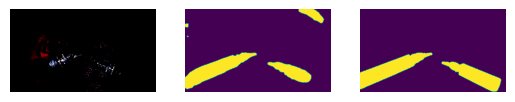

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


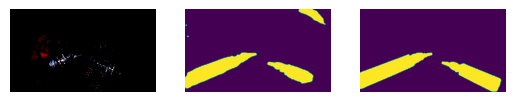

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


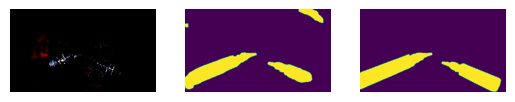

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


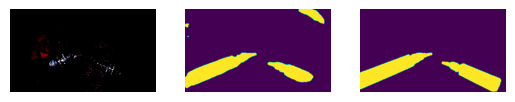

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


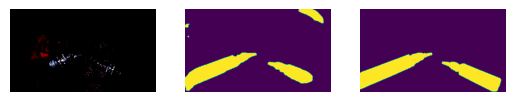

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


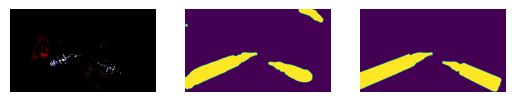

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


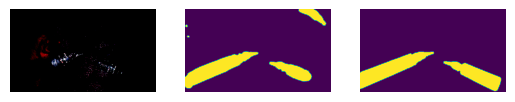

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


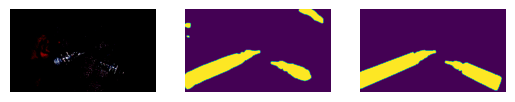

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


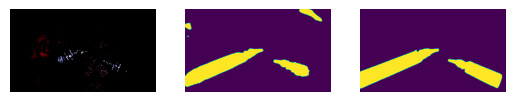

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


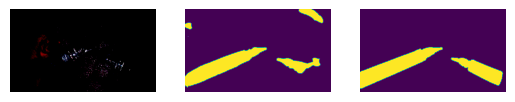

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


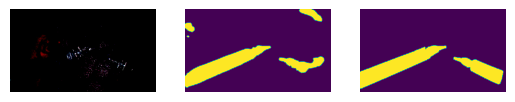

In [31]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_best_32_0.01.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader))
show_demo(segmentation_model_augmented, segmentation_test_dataloader)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\1179417263.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.7997178916136424


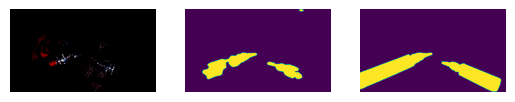

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


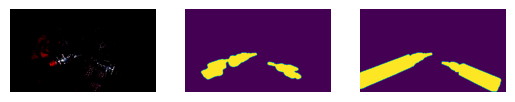

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


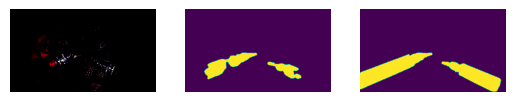

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


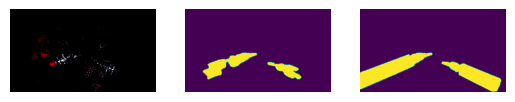

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


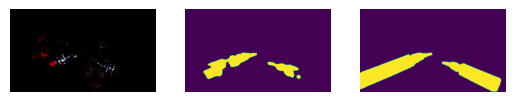

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


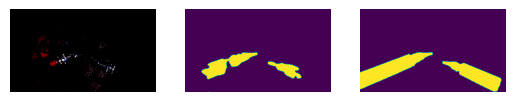

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


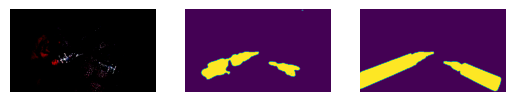

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


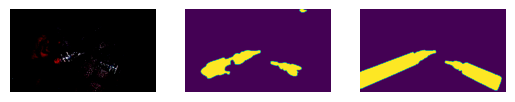

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


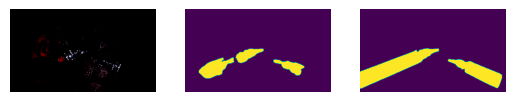

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


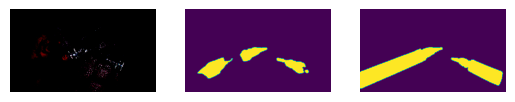

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


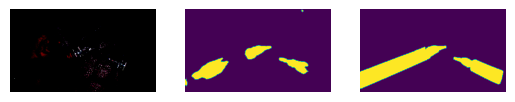

In [33]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\419548572.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("ResU

0.7011216924587885


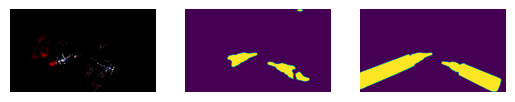

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


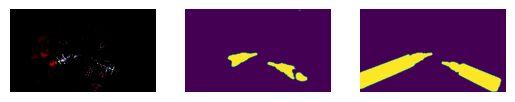

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


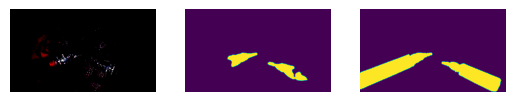

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


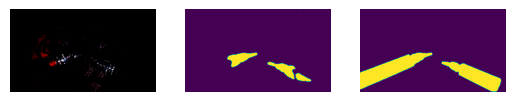

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


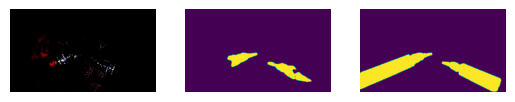

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


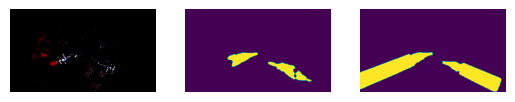

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


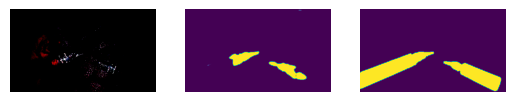

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


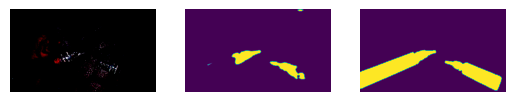

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


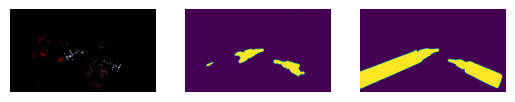

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


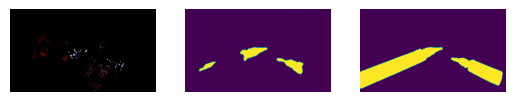

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


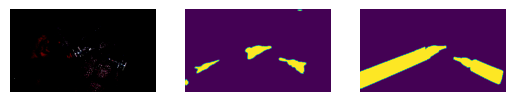

In [42]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_16_0.0001.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\3148846161.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.7018220786253612


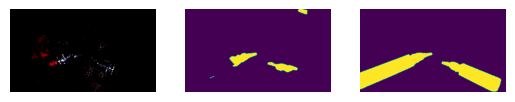

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


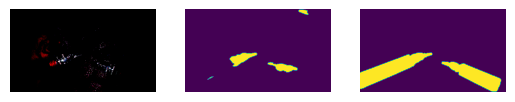

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


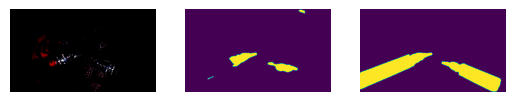

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


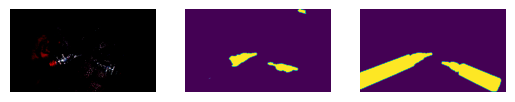

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


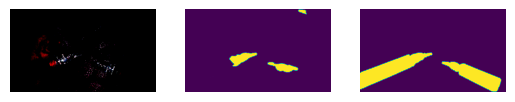

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


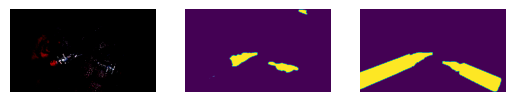

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


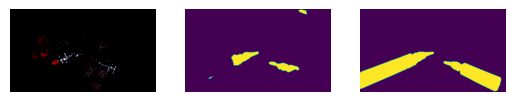

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


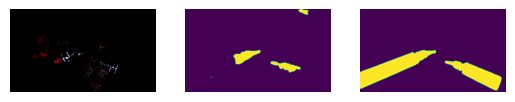

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


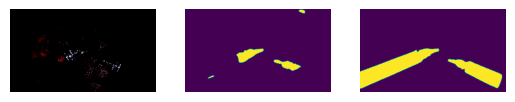

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


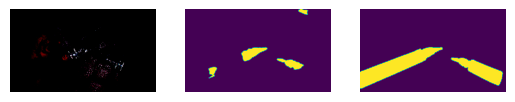

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


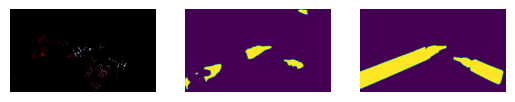

In [44]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_16_0.001.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\1467778258.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.7085239873329798


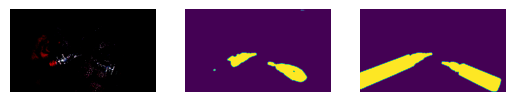

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


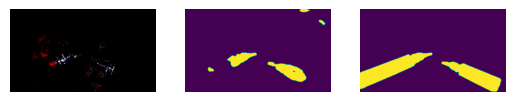

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


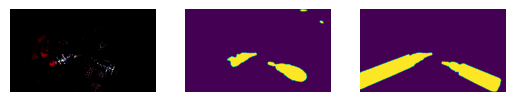

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


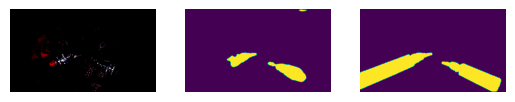

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


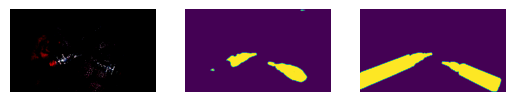

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


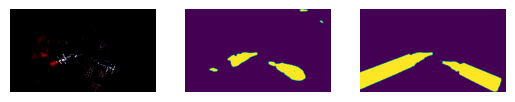

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


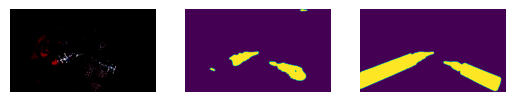

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


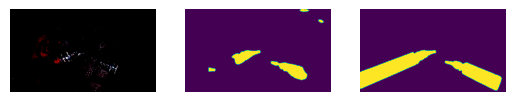

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


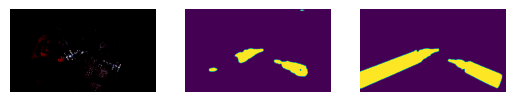

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


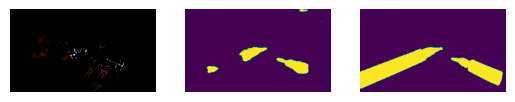

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


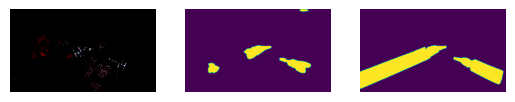

In [46]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_16_0.005.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\3125114075.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.6769373469551404


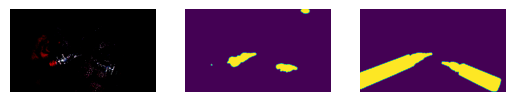

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


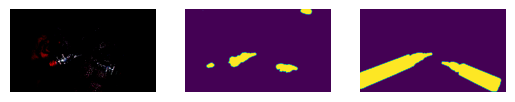

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


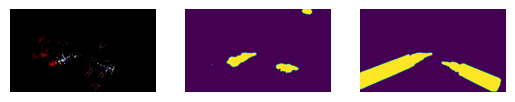

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


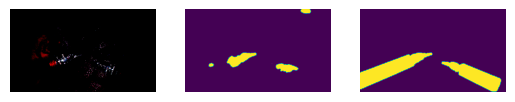

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


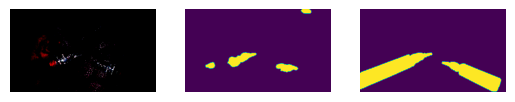

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


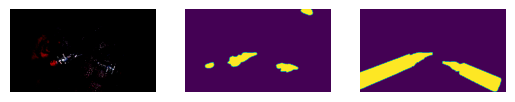

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


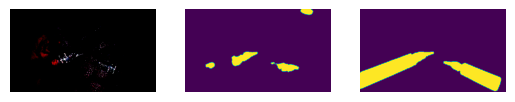

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


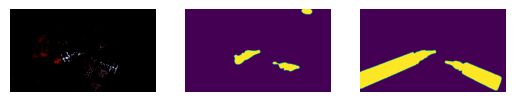

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


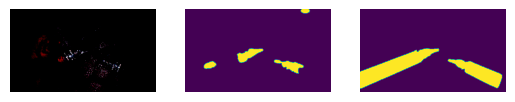

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


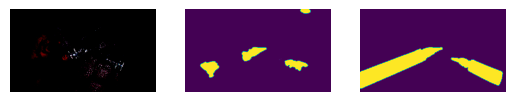

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


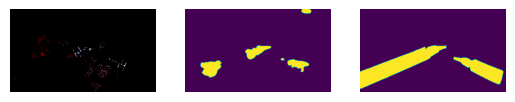

In [48]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_16_0.01.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\1412944863.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.49885758966207505


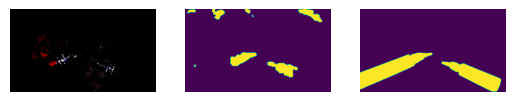

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


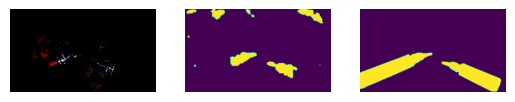

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


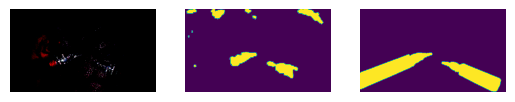

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


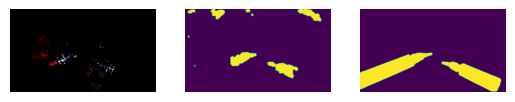

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


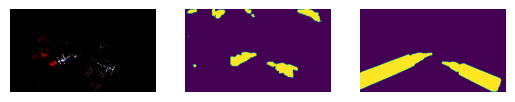

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


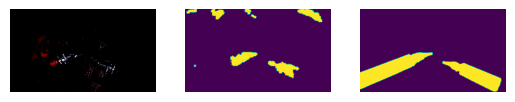

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


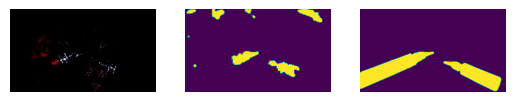

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


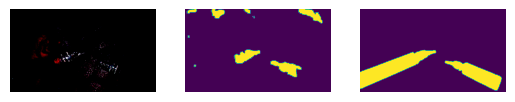

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


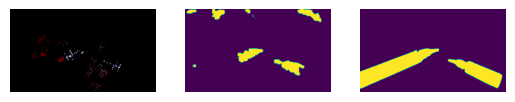

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


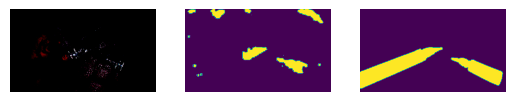

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


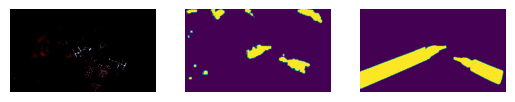

In [50]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_16_0.1.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\3186642837.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.6631183546781539


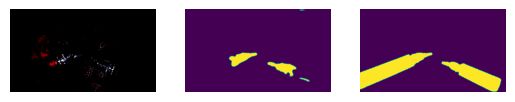

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


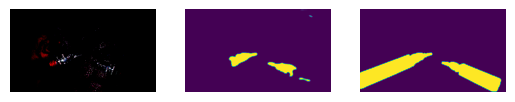

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


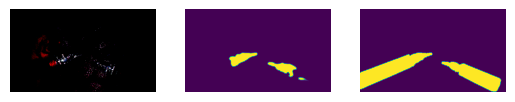

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


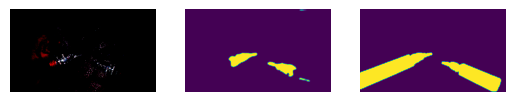

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


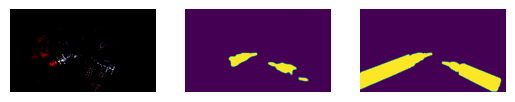

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


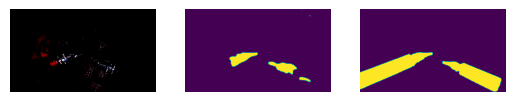

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


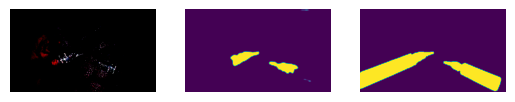

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


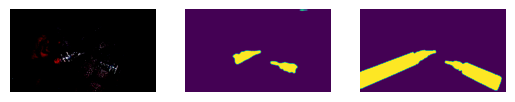

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


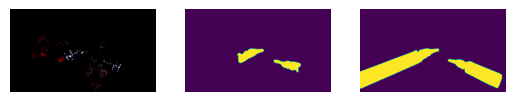

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


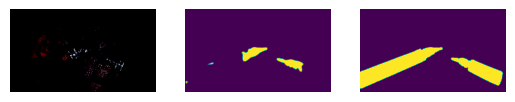

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


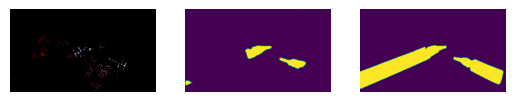

In [52]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_32_0.0001.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\197672984.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("ResU

0.6940703356266021


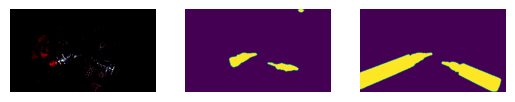

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


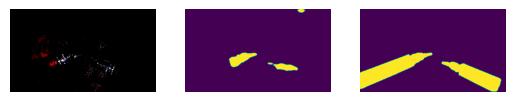

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


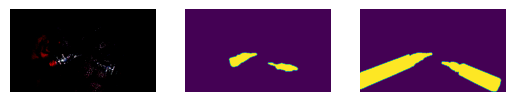

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


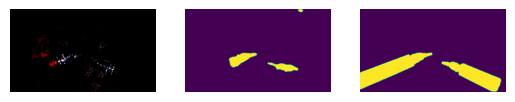

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


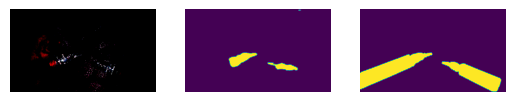

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


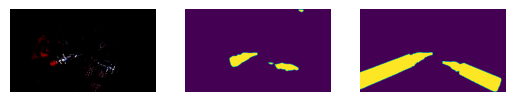

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


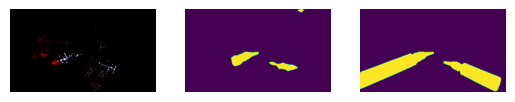

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


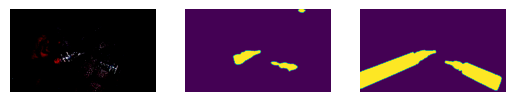

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


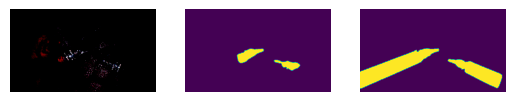

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


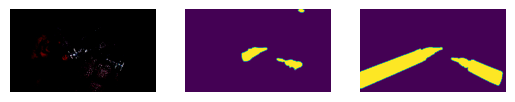

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


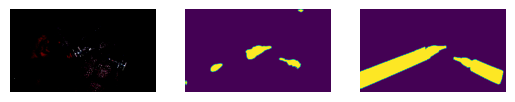

In [54]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_32_0.001.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\2217600053.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.5847433639069398


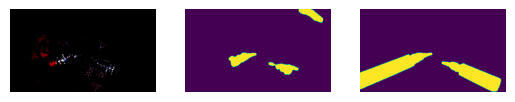

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


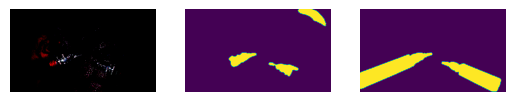

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


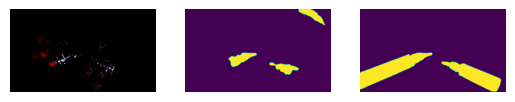

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


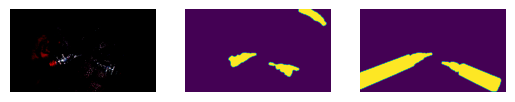

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


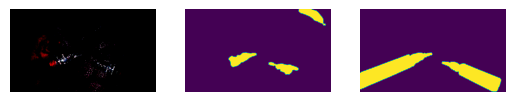

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


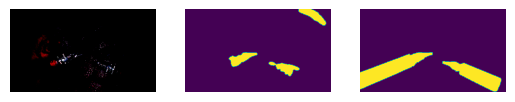

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


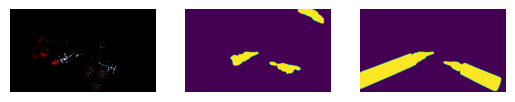

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


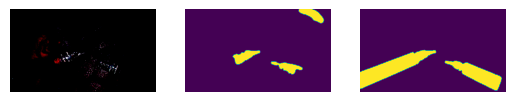

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


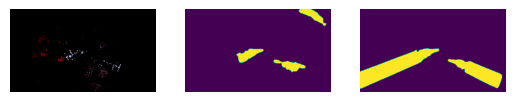

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


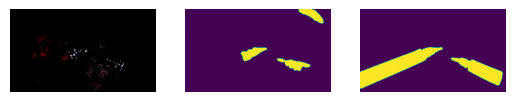

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


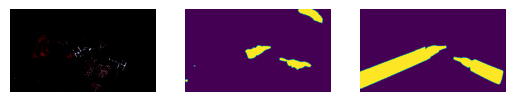

In [55]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_32_0.01.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14860\3231049939.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model_augmented.load_state_dict(torch.load("Res

0.6899809702237447


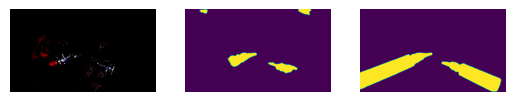

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


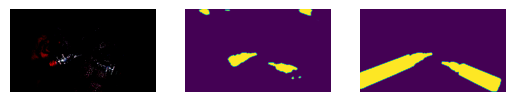

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


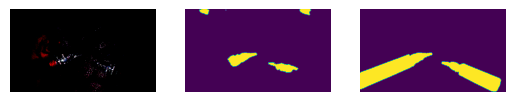

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


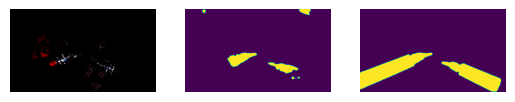

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


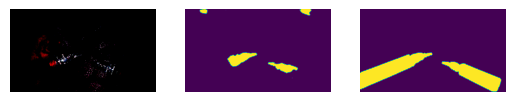

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


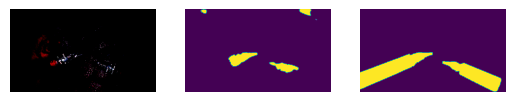

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


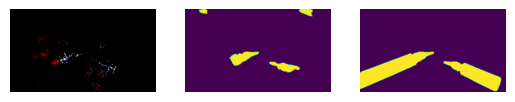

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


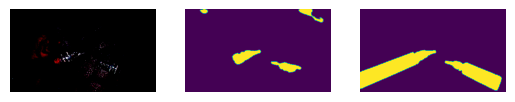

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


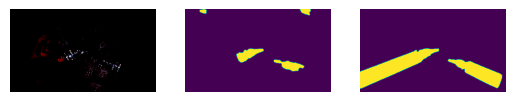

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


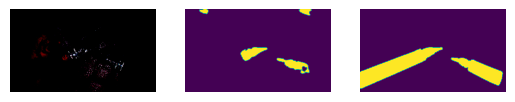

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


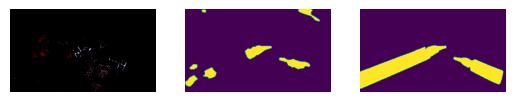

In [60]:
segmentation_model_augmented.load_state_dict(torch.load("ResUnet_augmented_32_0.005.model"))
print(DICE(segmentation_model_augmented, segmentation_test_dataloader_blood))
show_demo(segmentation_model_augmented, segmentation_test_dataloader_blood)